<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="../../figures/PDSH-cover-small.png">

*This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*

*The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT). If you find this content useful, please consider supporting the work by [buying the book](http://shop.oreilly.com/product/0636920034919.do)!*

## Thinking about Model Validation

In principle, model validation is very simple: after choosing a model and its hyperparameters, we can estimate how effective it is by applying it to some of the training data and comparing the prediction to the known value.

The following sections first show a naive approach to model validation and why it
fails, before exploring the use of holdout sets and cross-validation for more robust
model evaluation.

### Model validation the wrong way

Let's demonstrate the naive approach to validation using the Iris data, which we saw in the previous section.
We will start by loading the data:

In [42]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target

Next we choose a model and hyperparameters. Here we'll use a *k*-neighbors classifier with ``n_neighbors=1``.
This is a very simple and intuitive model that says "the label of an unknown point is the same as the label of its closest training point:"

In [43]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1)

Then we train the model, and use it to predict labels for data we already know:

In [44]:
model.fit(X, y)
y_model = model.predict(X)

Finally, we compute the fraction of correctly labeled points:

In [4]:
from sklearn.metrics import accuracy_score
accuracy_score(y, y_model)

1.0

We see an accuracy score of 1.0, which indicates that 100% of points were correctly labeled by our model!
But is this truly measuring the expected accuracy? Have we really come upon a model that we expect to be correct 100% of the time?

As you may have gathered, the answer is no.
In fact, this approach contains a fundamental flaw: *it trains and evaluates the model on the same data*.
Furthermore, the nearest neighbor model is an *instance-based* estimator that simply stores the training data, and predicts labels by comparing new data to these stored points: except in contrived cases, it will get 100% accuracy *every time!*

### Model validation the right way: Holdout sets

So what can be done?
A better sense of a model's performance can be found using what's known as a *holdout set*: that is, we hold back some subset of the data from the training of the model, and then use this holdout set to check the model performance.

We see here a more reasonable result: the nearest-neighbor classifier is about 90% accurate on this hold-out set.
The hold-out set is similar to unknown data, because the model has not "seen" it before.

### Model validation via cross-validation

One disadvantage of using a holdout set for model validation is that we have lost a portion of our data to the model training.
In the above case, half the dataset does not contribute to the training of the model!
This is not optimal, and can cause problems – especially if the initial set of training data is small.

One way to address this is to use *cross-validation*; that is, to do a sequence of fits where each subset of the data is used both as a training set and as a validation set.
Visually, it might look something like this:

![](../../figures/05.03-2-fold-CV.png)

Here we do two validation trials, alternately using each half of the data as a holdout set.
Using the split data from before, we could implement it like this:

What comes out are two accuracy scores, which we could combine (by, say, taking the mean) to get a better measure of the global model performance.
This particular form of cross-validation is a *two-fold cross-validation*—that is, one in which we have split the data into two sets and used each in turn as a validation set.

We could expand on this idea to use even more trials, and more folds in the data—for example, here is a visual depiction of five-fold cross-validation:

![](../../figures/05.03-5-fold-CV.png)

Here we split the data into five groups, and use each of them in turn to evaluate the model fit on the other 4/5 of the data.
This would be rather tedious to do by hand, and so we can use Scikit-Learn's ``cross_val_score`` convenience routine to do it succinctly.

**Note:** Skipping discussion and example of ``cross_val_score``

Other cross-validation schemes can be used similarly.
For a description of what is available in Scikit-Learn, use IPython to explore the ``sklearn.cross_validation`` submodule, or take a look at Scikit-Learn's online [cross-validation documentation](http://scikit-learn.org/stable/modules/cross_validation.html).

## Selecting the Best Model

Now that we've seen the basics of validation and cross-validation, we will go into a litte more depth regarding model selection and selection of hyperparameters.
These issues are some of the most important aspects of the practice of machine learning, and I find that this information is often glossed over in introductory machine learning tutorials.

Of core importance is the following question: *if our estimator is underperforming, how should we move forward?*
There are several possible answers:

- Use a more complicated/more flexible model
- Use a less complicated/less flexible model
- Gather more training samples
- Gather more data to add features to each sample

The answer to this question is often counter-intuitive.
In particular, sometimes using a more complicated model will give worse results, and adding more training samples may not improve your results!
The ability to determine what steps will improve your model is what separates the successful machine learning practitioners from the unsuccessful.

### The Bias-variance trade-off

Fundamentally, the question of "the best model" is about finding a sweet spot in the tradeoff between *bias* and *variance*.
Consider the following figure, which presents two regression fits to the same dataset:

It is clear that neither of these models is a particularly good fit to the data, but they fail in different ways.

The model on the left attempts to find a straight-line fit through the data.
Because the data are intrinsically more complicated than a straight line, the straight-line model will never be able to describe this dataset well.
Such a model is said to *underfit* the data: that is, it does not have enough model flexibility to suitably account for all the features in the data; another way of saying this is that the model has high *bias*.

The model on the right attempts to fit a high-order polynomial through the data.
Here the model fit has enough flexibility to nearly perfectly account for the fine features in the data, but even though it very accurately describes the training data, its precise form seems to be more reflective of the particular noise properties of the data rather than the intrinsic properties of whatever process generated that data.
Such a model is said to *overfit* the data: that is, it has so much model flexibility that the model ends up accounting for random errors as well as the underlying data distribution; another way of saying this is that the model has high *variance*.

To look at this in another light, consider what happens if we use these two models to predict the y-value for some new data.
In the following diagrams, the red/lighter points indicate data that is omitted from the training set:

The score here is the $R^2$ score, or [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination), which measures how well a model performs relative to a simple mean of the target values. $R^2=1$ indicates a perfect match, $R^2=0$ indicates the model does no better than simply taking the mean of the data, and negative values mean even worse models.
From the scores associated with these two models, we can make an observation that holds more generally:

- For high-bias models, the performance of the model on the validation set is similar to the performance on the training set.
- For high-variance models, the performance of the model on the validation set is far worse than the performance on the training set.

# Feature Engineering

The previous sections outline the fundamental ideas of machine learning, but all of the examples assume that you have numerical data in a tidy, ``[n_samples, n_features]`` format.
In the real world, data rarely comes in such a form.
With this in mind, one of the more important steps in using machine learning in practice is *feature engineering*: that is, taking whatever information you have about your problem and turning it into numbers that you can use to build your feature matrix.

In this section, we will cover a few common examples of feature engineering tasks: features for representing *categorical data*, features for representing *text*, and features for representing *images*.
Additionally, we will discuss *derived features* for increasing model complexity and *imputation* of missing data.
Often this process is known as *vectorization*, as it involves converting arbitrary data into well-behaved vectors.

## Categorical Features

One common type of non-numerical data is *categorical* data.
For example, imagine you are exploring some data on housing prices, and along with numerical features like "price" and "rooms", you also have "neighborhood" information.
For example, your data might look something like this:

In [5]:
data = [
    {'price': 850000, 'rooms': 4, 'neighborhood': 'Queen Anne'},
    {'price': 700000, 'rooms': 3, 'neighborhood': 'Fremont'},
    {'price': 650000, 'rooms': 3, 'neighborhood': 'Wallingford'},
    {'price': 600000, 'rooms': 2, 'neighborhood': 'Fremont'}
]

You might be tempted to encode this data with a straightforward numerical mapping:

In [6]:
{'Queen Anne': 1, 'Fremont': 2, 'Wallingford': 3};

It turns out that this is not generally a useful approach in Scikit-Learn: the package's models make the fundamental assumption that numerical features reflect algebraic quantities.
Thus such a mapping would imply, for example, that *Queen Anne < Fremont < Wallingford*, or even that *Wallingford - Queen Anne = Fremont*, which (niche demographic jokes aside) does not make much sense.

In this case, one proven technique is to use *one-hot encoding*, which effectively creates extra columns indicating the presence or absence of a category with a value of 1 or 0, respectively.
When your data comes as a list of dictionaries, Scikit-Learn's ``DictVectorizer`` will do this for you:

In [7]:
from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer(sparse=False, dtype=int)
vec.fit_transform(data)

array([[     0,      1,      0, 850000,      4],
       [     1,      0,      0, 700000,      3],
       [     0,      0,      1, 650000,      3],
       [     1,      0,      0, 600000,      2]])

Notice that the 'neighborhood' column has been expanded into three separate columns, representing the three neighborhood labels, and that each row has a 1 in the column associated with its neighborhood.
With these categorical features thus encoded, you can proceed as normal with fitting a Scikit-Learn model.

To see the meaning of each column, you can inspect the feature names:

In [8]:
vec.get_feature_names()

['neighborhood=Fremont',
 'neighborhood=Queen Anne',
 'neighborhood=Wallingford',
 'price',
 'rooms']

There is one clear disadvantage of this approach: if your category has many possible values, this can *greatly* increase the size of your dataset.
However, because the encoded data contains mostly zeros, a sparse output can be a very efficient solution:

In [9]:
vec = DictVectorizer(sparse=True, dtype=int)
vec.fit_transform(data)

<4x5 sparse matrix of type '<class 'numpy.int64'>'
	with 12 stored elements in Compressed Sparse Row format>

Many (though not yet all) of the Scikit-Learn estimators accept such sparse inputs when fitting and evaluating models. ``sklearn.preprocessing.OneHotEncoder`` and ``sklearn.feature_extraction.FeatureHasher`` are two additional tools that Scikit-Learn includes to support this type of encoding.

## Derived Features

Another useful type of feature is one that is mathematically derived from some input features.
We saw an example of this above, in Hyperparameters and Model Validation when we constructed *polynomial features* from our input data.
We saw that we could convert a linear regression into a polynomial regression not by changing the model, but by transforming the input!
This is sometimes known as *basis function regression*, and is explored further below.

For example, this data clearly cannot be well described by a straight line:

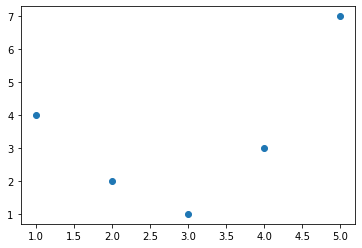

In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

x = np.array([1, 2, 3, 4, 5])
y = np.array([4, 2, 1, 3, 7])
plt.scatter(x, y);

Still, we can fit a line to the data using ``LinearRegression`` and get the optimal result:

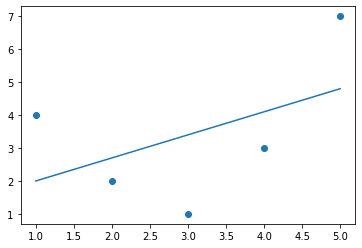

In [11]:
from sklearn.linear_model import LinearRegression
X = x[:, np.newaxis]
model = LinearRegression().fit(X, y)
yfit = model.predict(X)
plt.scatter(x, y)
plt.plot(x, yfit);

It's clear that we need a more sophisticated model to describe the relationship between $x$ and $y$.

One approach to this is to transform the data, adding extra columns of features to drive more flexibility in the model.
For example, we can add polynomial features to the data this way:

In [12]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3, include_bias=False)
X2 = poly.fit_transform(X)
print(X2)

[[  1.   1.   1.]
 [  2.   4.   8.]
 [  3.   9.  27.]
 [  4.  16.  64.]
 [  5.  25. 125.]]


The derived feature matrix has one column representing $x$, and a second column representing $x^2$, and a third column representing $x^3$.
Computing a linear regression on this expanded input gives a much closer fit to our data:

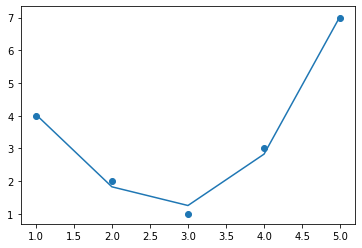

In [13]:
model = LinearRegression().fit(X2, y)
yfit = model.predict(X2)
plt.scatter(x, y)
plt.plot(x, yfit);

This idea of improving a model not by changing the model, but by transforming the inputs, is _fundamental_ to many of the more powerful machine learning methods.

## Imputation of Missing Data

Another common need in feature engineering is handling of missing data. For example, we might have a dataset that looks like this:

In [14]:
from numpy import nan
X = np.array([[ nan, 0,   3  ],
              [ 3,   7,   9  ],
              [ 3,   5,   2  ],
              [ 4,   nan, 6  ],
              [ 8,   8,   1  ]])
y = np.array([14, 16, -1,  8, -5])

When applying a typical machine learning model to such data, we will need to first replace such missing data with some appropriate fill value.
This is known as *imputation* of missing values, and strategies range from simple (e.g., replacing missing values with the mean of the column) to sophisticated (e.g., using matrix completion or a robust model to handle such data).

The sophisticated approaches tend to be very application-specific, and we won't dive into them here.
For a baseline imputation approach, using the mean, median, or most frequent value, Scikit-Learn provides the ``Imputer`` class **but we will be skipping it here.**

# In Depth: Naive Bayes Classification

The previous four sections have given a general overview of the concepts of machine learning.
In this section and the ones that follow, we will be taking a closer look at several specific algorithms for supervised and unsupervised learning, starting here with naive Bayes classification.

Naive Bayes models are a group of extremely fast and simple classification algorithms that are often suitable for very high-dimensional datasets.
Because they are so fast and have so few tunable parameters, they end up being very useful as a quick-and-dirty baseline for a classification problem.
This section will focus on an intuitive explanation of how naive Bayes classifiers work, followed by a couple examples of them in action on some datasets.

## Bayesian Classification

Naive Bayes classifiers are built on Bayesian classification methods.
These rely on Bayes's theorem, which is an equation describing the relationship of conditional probabilities of statistical quantities.
In Bayesian classification, we're interested in finding the probability of a label given some observed features, which we can write as $P(L~|~{\rm features})$.
Bayes's theorem tells us how to express this in terms of quantities we can compute more directly:

$$
P(L~|~{\rm features}) = \frac{P({\rm features}~|~L)P(L)}{P({\rm features})}
$$

If we are trying to decide between two labels—let's call them $L_1$ and $L_2$—then one way to make this decision is to compute the ratio of the posterior probabilities for each label:

$$
\frac{P(L_1~|~{\rm features})}{P(L_2~|~{\rm features})} = \frac{P({\rm features}~|~L_1)}{P({\rm features}~|~L_2)}\frac{P(L_1)}{P(L_2)}
$$

All we need now is some model by which we can compute $P({\rm features}~|~L_i)$ for each label.
Such a model is called a *generative model* because it specifies the hypothetical random process that generates the data.
Specifying this generative model for each label is the main piece of the training of such a Bayesian classifier.
The general version of such a training step is a very difficult task, but we can make it simpler through the use of some simplifying assumptions about the form of this model.

This is where the "naive" in "naive Bayes" comes in: if we make very naive assumptions about the generative model for each label, we can find a rough approximation of the generative model for each class, and then proceed with the Bayesian classification.
Different types of naive Bayes classifiers rest on different naive assumptions about the data, and we will examine a few of these in the following sections.

We begin with the standard imports:

In [15]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Gaussian Naive Bayes

Perhaps the easiest naive Bayes classifier to understand is Gaussian naive Bayes.
In this classifier, the assumption is that *data from each label is drawn from a simple Gaussian distribution*.
Imagine that you have the following data:

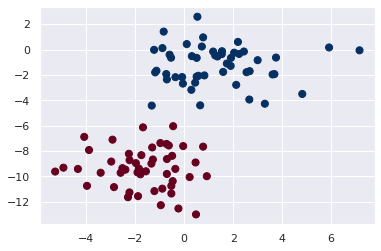

In [16]:
from sklearn.datasets import make_blobs
X, y = make_blobs(100, 2, centers=2, random_state=2, cluster_std=1.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu');

One extremely fast way to create a simple model is to assume that the data is described by a Gaussian distribution with no covariance between dimensions.
This model can be fit by simply finding the mean and standard deviation of the points within each label, which is all you need to define such a distribution.
The result of this naive Gaussian assumption is shown in the following figure:

The ellipses here represent the Gaussian generative model for each label, with larger probability toward the center of the ellipses.
With this generative model in place for each class, we have a simple recipe to compute the likelihood $P({\rm features}~|~L_1)$ for any data point, and thus we can quickly compute the posterior ratio and determine which label is the most probable for a given point.

This procedure is implemented in Scikit-Learn's ``sklearn.naive_bayes.GaussianNB`` estimator:

In [17]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X, y);

Now let's generate some new data and predict the label:

In [18]:
rng = np.random.RandomState(0)
Xnew = [-6, -14] + [14, 18] * rng.rand(2000, 2)
ynew = model.predict(Xnew)

Now we can plot this new data to get an idea of where the decision boundary is:

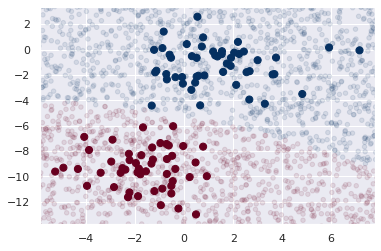

In [19]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
lim = plt.axis()
plt.scatter(Xnew[:, 0], Xnew[:, 1], c=ynew, s=20, cmap='RdBu', alpha=0.1)
plt.axis(lim);

We see a slightly curved boundary in the classifications—in general, the boundary in Gaussian naive Bayes is quadratic.

A nice piece of this Bayesian formalism is that it naturally allows for probabilistic classification, which we can compute using the ``predict_proba`` method:

In [20]:
yprob = model.predict_proba(Xnew)
yprob[-8:].round(2)

array([[0.89, 0.11],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.15, 0.85]])

The columns give the posterior probabilities of the first and second label, respectively.
If you are looking for estimates of uncertainty in your classification, Bayesian approaches like this can be a useful approach.

Of course, the final classification will only be as good as the model assumptions that lead to it, which is why Gaussian naive Bayes often does not produce very good results.
Still, in many cases—especially as the number of features becomes large—this assumption is not detrimental enough to prevent Gaussian naive Bayes from being a useful method.

## Multinomial Naive Bayes

The Gaussian assumption just described is by no means the only simple assumption that could be used to specify the generative distribution for each label.
Another useful example is multinomial naive Bayes, where the features are assumed to be generated from a simple multinomial distribution.
The multinomial distribution describes the probability of observing counts among a number of categories, and thus multinomial naive Bayes is most appropriate for features that represent counts or count rates.

The idea is precisely the same as before, except that instead of modeling the data distribution with the best-fit Gaussian, we model the data distribuiton with a best-fit multinomial distribution.

### Example: Classifying Text

One place where multinomial naive Bayes is often used is in text classification, where the features are related to word counts or frequencies within the documents to be classified.
We discussed the extraction of such features from text in [Feature Engineering](05.04-Feature-Engineering.ipynb); here we will use the sparse word count features from the 20 Newsgroups corpus to show how we might classify these short documents into categories.

Let's download the data and take a look at the target names:

In [21]:
from sklearn.datasets import fetch_20newsgroups

data = fetch_20newsgroups()
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

For simplicity here, we will select just a few of these categories, and download the training and testing set:

In [22]:
categories = ['talk.religion.misc', 'soc.religion.christian',
              'sci.space', 'comp.graphics']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

Here is a representative entry from the data:

In [23]:
print(train.data[5])

From: dmcgee@uluhe.soest.hawaii.edu (Don McGee)
Subject: Federal Hearing
Originator: dmcgee@uluhe
Organization: School of Ocean and Earth Science and Technology
Distribution: usa
Lines: 10


Fact or rumor....?  Madalyn Murray O'Hare an atheist who eliminated the
use of the bible reading and prayer in public schools 15 years ago is now
going to appear before the FCC with a petition to stop the reading of the
Gospel on the airways of America.  And she is also campaigning to remove
Christmas programs, songs, etc from the public schools.  If it is true
then mail to Federal Communications Commission 1919 H Street Washington DC
20054 expressing your opposition to her request.  Reference Petition number

2493.



In order to use this data for machine learning, we need to be able to convert the content of each string into a vector of numbers.
For this we will use the TF-IDF vectorizer (discussed in [Feature Engineering](05.04-Feature-Engineering.ipynb)), and create a pipeline that attaches it to a multinomial naive Bayes classifier:

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), MultinomialNB())

With this pipeline, we can apply the model to the training data, and predict labels for the test data:

In [25]:
model.fit(train.data, train.target)
labels = model.predict(test.data)

Now that we have predicted the labels for the test data, we can evaluate them to learn about the performance of the estimator.
For example, here is the confusion matrix between the true and predicted labels for the test data:

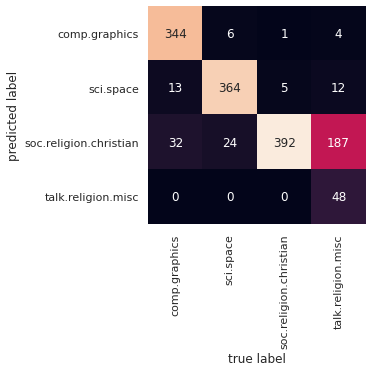

In [26]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(test.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=train.target_names, yticklabels=train.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

Evidently, even this very simple classifier can successfully separate space talk from computer talk, but it gets confused between talk about religion and talk about Christianity.
This is perhaps an expected area of confusion!

The very cool thing here is that we now have the tools to determine the category for *any* string, using the ``predict()`` method of this pipeline.
Here's a quick utility function that will return the prediction for a single string:

In [27]:
def predict_category(s, train=train, model=model):
    pred = model.predict([s])
    return train.target_names[pred[0]]

Let's try it out:

In [28]:
predict_category('sending a payload to the ISS')

'sci.space'

In [29]:
predict_category('discussing islam vs atheism')

'soc.religion.christian'

In [30]:
predict_category('determining the screen resolution')

'comp.graphics'

Remember that this is nothing more sophisticated than a simple probability model for the (weighted) frequency of each word in the string; nevertheless, the result is striking.
Even a very naive algorithm, when used carefully and trained on a large set of high-dimensional data, can be surprisingly effective.

## When to Use Naive Bayes

Because naive Bayesian classifiers make such stringent assumptions about data, they will generally not perform as well as a more complicated model.
That said, they have several advantages:

- They are extremely fast for both training and prediction
- They provide straightforward probabilistic prediction
- They are often very easily interpretable
- They have very few (if any) tunable parameters

These advantages mean a naive Bayesian classifier is often a good choice as an initial baseline classification.
If it performs suitably, then congratulations: you have a very fast, very interpretable classifier for your problem.
If it does not perform well, then you can begin exploring more sophisticated models, with some baseline knowledge of how well they should perform.

Naive Bayes classifiers tend to perform especially well in one of the following situations:

- When the naive assumptions actually match the data (very rare in practice)
- For very well-separated categories, when model complexity is less important
- For very high-dimensional data, when model complexity is less important

The last two points seem distinct, but they actually are related: as the dimension of a dataset grows, it is much less likely for any two points to be found close together (after all, they must be close in *every single dimension* to be close overall).
This means that clusters in high dimensions tend to be more separated, on average, than clusters in low dimensions, assuming the new dimensions actually add information.
For this reason, simplistic classifiers like naive Bayes tend to work as well or better than more complicated classifiers as the dimensionality grows: once you have enough data, even a simple model can be very powerful.

# In Depth: Linear Regression

Just as naive Bayes (discussed earlier in [In Depth: Naive Bayes Classification](05.05-Naive-Bayes.ipynb)) is a good starting point for classification tasks, linear regression models are a good starting point for regression tasks.
Such models are popular because they can be fit very quickly, and are very interpretable.
You are probably familiar with the simplest form of a linear regression model (i.e., fitting a straight line to data) but such models can be extended to model more complicated data behavior.

In this section we will start with a quick intuitive walk-through of the mathematics behind this well-known problem, before seeing how before moving on to see how linear models can be generalized to account for more complicated patterns in data.

We begin with the standard imports:

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## Simple Linear Regression

We will start with the most familiar linear regression, a straight-line fit to data.
A straight-line fit is a model of the form
$$
y = ax + b
$$
where $a$ is commonly known as the *slope*, and $b$ is commonly known as the *intercept*.

Consider the following data, which is scattered about a line with a slope of 2 and an intercept of -5:

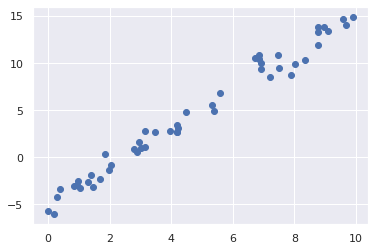

In [32]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y);

We can use Scikit-Learn's ``LinearRegression`` estimator to fit this data and construct the best-fit line:

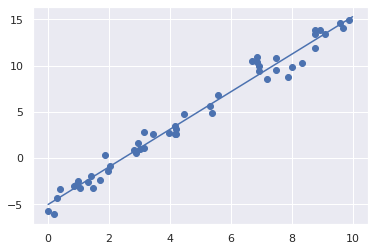

In [33]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

The slope and intercept of the data are contained in the model's fit parameters, which in Scikit-Learn are always marked by a trailing underscore.
Here the relevant parameters are ``coef_`` and ``intercept_``:

In [34]:
print("Model slope:    ", model.coef_[0])
print("Model intercept:", model.intercept_)

Model slope:     2.027208810360696
Model intercept: -4.9985770855532055


We see that the results are very close to the inputs, as we might hope.

The ``LinearRegression`` estimator is much more capable than this, however—in addition to simple straight-line fits, it can also handle multidimensional linear models of the form
$$
y = a_0 + a_1 x_1 + a_2 x_2 + \cdots
$$
where there are multiple $x$ values.
Geometrically, this is akin to fitting a plane to points in three dimensions, or fitting a hyper-plane to points in higher dimensions.

The multidimensional nature of such regressions makes them more difficult to visualize, but we can see one of these fits in action by building some example data, using NumPy's matrix multiplication operator:

In [35]:
rng = np.random.RandomState(1)
X = 10 * rng.rand(100, 3)
y = 0.5 + np.dot(X, [1.5, -2., 1.])

model.fit(X, y)
print(model.intercept_)
print(model.coef_)

0.5000000000000038
[ 1.5 -2.   1. ]


Here the $y$ data is constructed from three random $x$ values, and the linear regression recovers the coefficients used to construct the data.

In this way, we can use the single ``LinearRegression`` estimator to fit lines, planes, or hyperplanes to our data.
It still appears that this approach would be limited to strictly linear relationships between variables, but it turns out we can relax this as well.

## Basis Function Regression

One trick you can use to adapt linear regression to nonlinear relationships between variables is to transform the data according to *basis functions*.
The idea is to take our multidimensional linear model:
$$
y = a_0 + a_1 x_1 + a_2 x_2 + a_3 x_3 + \cdots
$$
and build the $x_1, x_2, x_3,$ and so on, from our single-dimensional input $x$.
That is, we let $x_n = f_n(x)$, where $f_n()$ is some function that transforms our data.

For example, if $f_n(x) = x^n$, our model becomes a polynomial regression:
$$
y = a_0 + a_1 x + a_2 x^2 + a_3 x^3 + \cdots
$$
Notice that this is *still a linear model*—the linearity refers to the fact that the coefficients $a_n$ never multiply or divide each other.
What we have effectively done is taken our one-dimensional $x$ values and projected them into a higher dimension, so that a linear fit can fit more complicated relationships between $x$ and $y$.

### Polynomial basis functions

This polynomial projection is useful enough that it is built into Scikit-Learn, using the ``PolynomialFeatures`` transformer:

In [36]:
from sklearn.preprocessing import PolynomialFeatures
x = np.array([2, 3, 4])
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x[:, None])

array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

We see here that the transformer has converted our one-dimensional array into a three-dimensional array by taking the exponent of each value.
This new, higher-dimensional data representation can then be plugged into a linear regression.

The cleanest way to accomplish this is to use a pipeline.
Let's make a 7th-degree polynomial model in this way:

In [37]:
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(7),
                           LinearRegression())

With this transform in place, we can use the linear model to fit much more complicated relationships between $x$ and $y$. 
For example, here is a sine wave with noise:

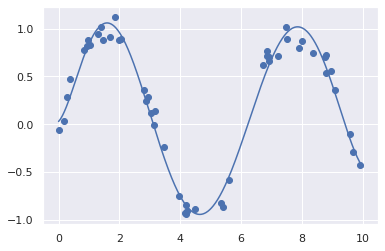

In [38]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

Our linear model, through the use of 7th-order polynomial basis functions, can provide an excellent fit to this non-linear data!

### Gaussian basis functions

Of course, other basis functions are possible.
For example, one useful pattern is to fit a model that is not a sum of polynomial bases, but a sum of Gaussian bases.
The result might look something like the following figure:

The shaded regions in the plot are the scaled basis functions, and when added together they reproduce the smooth curve through the data.
These Gaussian basis functions are not built into Scikit-Learn, but we can write a custom transformer that will create them, as shown here and illustrated in the following figure (Scikit-Learn transformers are implemented as Python classes; reading Scikit-Learn's source is a good way to see how they can be created):

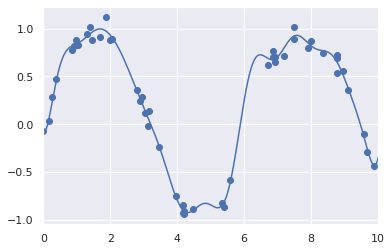

In [39]:
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for one-dimensional input"""
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
        
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                 self.width_, axis=1)
    
gauss_model = make_pipeline(GaussianFeatures(20),
                            LinearRegression())
gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.xlim(0, 10);

We put this example here just to make clear that there is nothing magic about polynomial basis functions: if you have some sort of intuition into the generating process of your data that makes you think one basis or another might be appropriate, you can use them as well.

![The end](https://live.staticflickr.com/32/89187454_3ae6aded89_b.jpg)